# CSE 258 - Assignment 2

In [ ]:
import gzip
import plotly.graph_objects as go
import tensorflow as tf
from IPython.display import Image

In [2]:
dataFolder = 'data'

## Reduce dataset

In [3]:
def readData(path):
    data = []
    for line in gzip.open(path):
        d = eval(line)
        data.append(d)
        if len(data) > 100000:
            break
    return data

In [4]:
places = list(readData(dataFolder + '/places.clean.json.gz'))

In [5]:
places[9]

{'name': 'Old Chicago',
 'price': '$$',
 'address': ['17960 NW Evergreen Pkwy', 'Beaverton, OR 97006'],
 'hours': [['Monday', [['11:00 am--1:00 am']]],
  ['Tuesday', [['11:00 am--1:00 am']]],
  ['Wednesday', [['11:00 am--1:00 am']]],
  ['Thursday', [['11:00 am--1:00 am']], 1],
  ['Friday', [['11:00 am--1:00 am']]],
  ['Saturday', [['11:00 am--1:00 am']]],
  ['Sunday', [['11:00 am--1:00 am']]]],
 'phone': '(503) 533-4650',
 'closed': False,
 'gPlusPlaceId': '118222137795476771294',
 'gps': [45.535176, -122.862242]}

## Exploratory data analysis

In [6]:
lat, long, text = [], [], []
for d in places:
    if d['gps']:
        lat.append(d['gps'][0])
        long.append(d['gps'][1])
        text.append(d['name'])

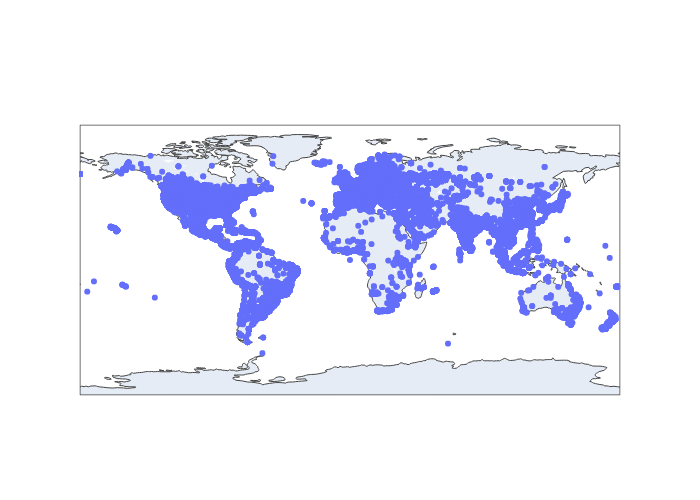

In [11]:
fig = go.Figure(data=go.Scattergeo(
        lon = long,
        lat = lat,
        text = text,
        mode = 'markers'
        ))
imgBytes = fig.to_image(format="png")
Image(imgBytes)

## Model

In [ ]:
class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p
    
    def predictSample(self, sampleU, sampleI, sampleJ):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        return beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
    

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

## Evaluate